
Project Title : “AI-Enhanced Portfolio Management for Equity Investments”

# Uploading Data Set

In [2]:
from google.colab import files
uploaded = files.upload()


Saving Stocks.zip to Stocks.zip


In [6]:
import zipfile

with zipfile.ZipFile("Stocks.zip", 'r') as zip_ref:
    zip_ref.extractall("stocks")



# Listing few columns for dataset Confirmation

In [7]:
# Listing a few files to confirm
import os
print(os.listdir("stocks")[:10])


['Stocks', '__MACOSX']


This code is used to quickly check and display the first 10 files or folders inside the stocks directory, which is helpful for confirming file names, data availability, or debugging file access issues.


# List Available Stock Files

In [10]:
import os

stock_files = os.listdir("stocks/Stocks")
print(stock_files[:10])  # show first 10 filenames


['glv.us.txt', 'xoxo.us.txt', 'abil.us.txt', 'fran.us.txt', 'tap-a.us.txt', 'vmm.us.txt', 'tcrz.us.txt', 'agm.us.txt', 'elec.us.txt', 'fwonk.us.txt']


This code helps verify that the "stocks/Stocks" directory exists and is correctly populated by displaying a sample of the files (up to 10). It's useful for confirming file structure before proceeding with data loading or analysis steps.

# Loading a Few Stock CSVs into a DataFrame

In [12]:
import pandas as pd

# Example: Picking any 5 stock files
selected_files = stock_files[:5]

# Dictionary to hold data
stock_data = {}

# Loading CSVs
for file in selected_files:
    ticker = file.replace('.us.txt', '')
    df = pd.read_csv(f"stocks/Stocks/{file}", parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    stock_data[ticker] = df

# Checking one stock’s data
stock_data[ticker].head()


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-08-23,88.5560,89.8020,88.5560,89.8020,362,0
2017-08-31,91.6300,91.6300,91.6300,91.6300,110,0
2017-09-20,86.5000,86.5000,86.5000,86.5000,115,0
2017-09-26,84.2123,84.2123,84.2123,84.2123,174,0
2017-09-27,84.2100,84.2100,83.8400,83.8400,651,0


This snippet is useful for loading and inspecting multiple stock price files, especially when working with a large dataset of individual company CSVs in a directory.

# Combining ‘Close’ Prices into One DataFrame

In [13]:
# Combining all close prices
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in stock_data.items()})

# Sorting by date
close_prices.sort_index(inplace=True)

# Showing result
close_prices.head()


,glv,xoxo,abil,fran,tap-a
Date,,,,,
2005-02-25,11.331,NaN,NaN,NaN,NaN
2005-02-28,11.227,NaN,NaN,NaN,NaN
2005-03-01,11.427,NaN,NaN,NaN,NaN
2005-03-02,11.236,NaN,NaN,NaN,NaN
2005-03-03,11.117,NaN,NaN,NaN,NaN


This step consolidates the daily closing prices of multiple stocks into one unified time series DataFrame, making it easier to perform analysis like correlation, returns calculation, or portfolio optimization.

# Exploratory Data Analysis

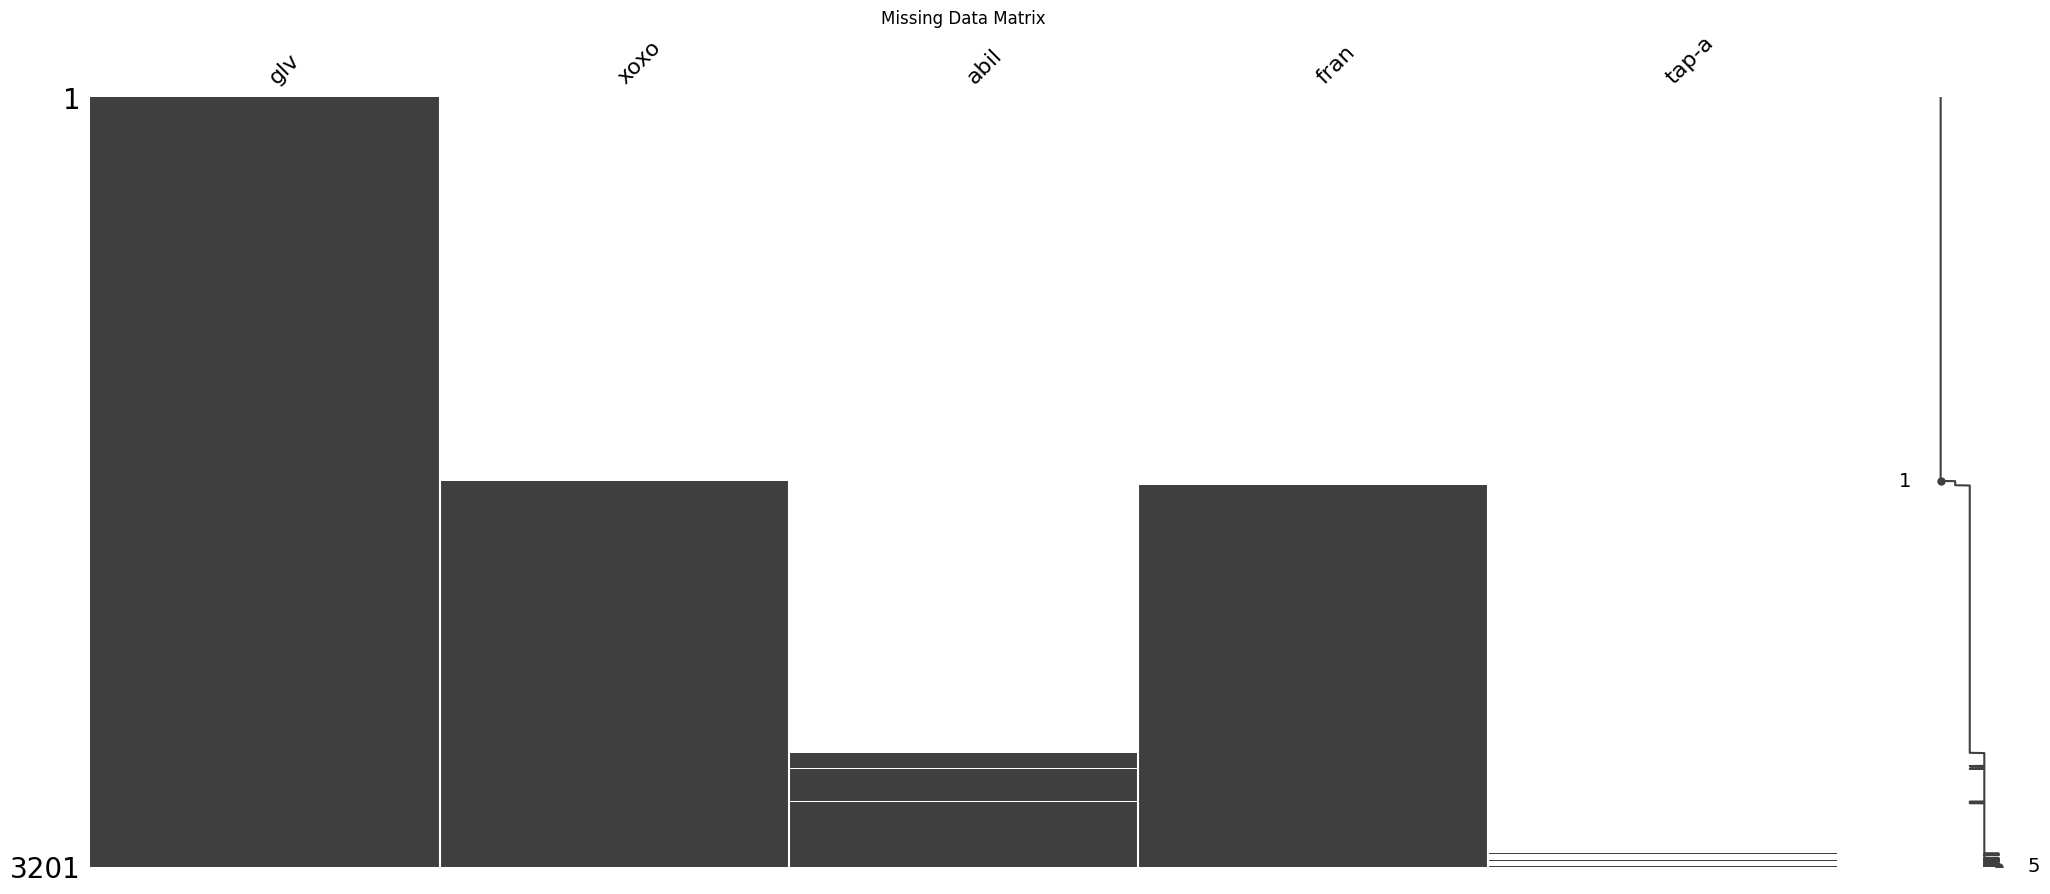

In [14]:
import missingno as msno
import matplotlib.pyplot as plt

# Checking for missing data
msno.matrix(close_prices)
plt.title("Missing Data Matrix")
plt.show()

# Forward-fill missing values
close_prices.ffill(inplace=True)


This step helps identify and handle missing values before performing time series modeling or analysis, ensuring continuity and avoiding errors from NaNs in computations.

In [15]:
# Final checking
print("Missing values after forward fill:\n", close_prices.isna().sum())

Missing values after forward fill:
 glv         0
xoxo     1596
abil     2726
fran     1614
tap-a    3144
dtype: int64


# Plotting Stock Price Trends (Line Chart)



<Figure size 1200x600 with 0 Axes>

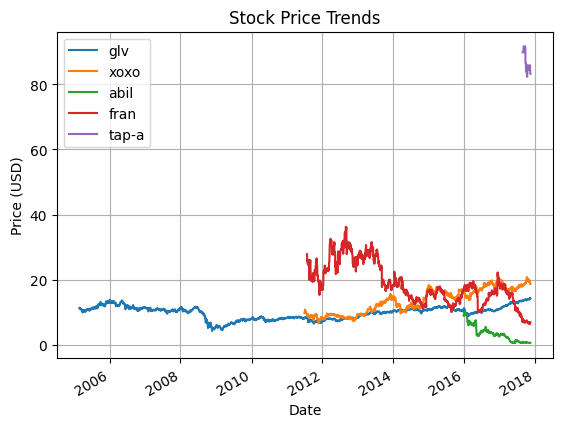

In [17]:
plt.figure(figsize=(12, 6))
close_prices.plot()
plt.title("Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend(loc='best')
plt.show()


This visualization provides a quick overview of how different stock prices have moved over time, allowing for trend comparison, pattern recognition, or anomaly detection.

# Computing and Plotting Cumulative Returns

<Figure size 1200x600 with 0 Axes>

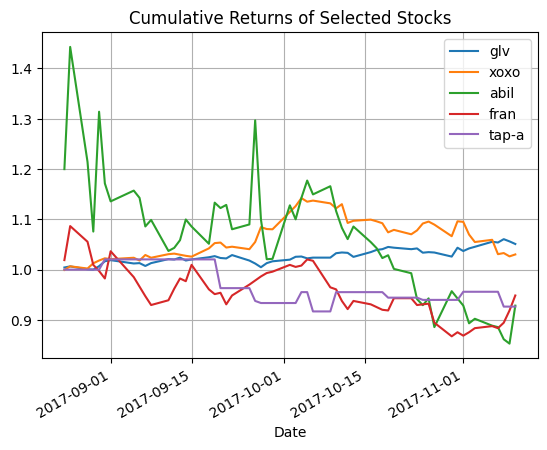

In [18]:
# Daily returns
returns = close_prices.pct_change().dropna()

# Cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plotting cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title("Cumulative Returns of Selected Stocks")
plt.grid(True)
plt.show()


This code is used to analyze the growth of investments in different stocks over time, enabling performance comparison and identifying trends in portfolio value.

# Plotting Daily Returns

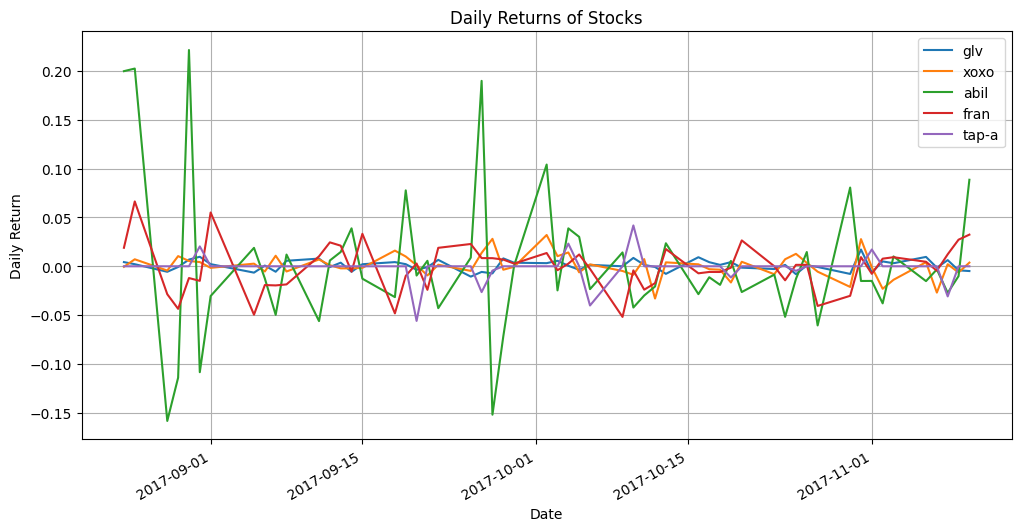

In [20]:
returns.plot(figsize=(12, 6), title="Daily Returns of Stocks")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()


This visualization shows the volatility and daily movement patterns of each stock, useful for identifying high-variance stocks, market reactions, or outliers in performance.

# Correlation Heatmap of Daily Returns

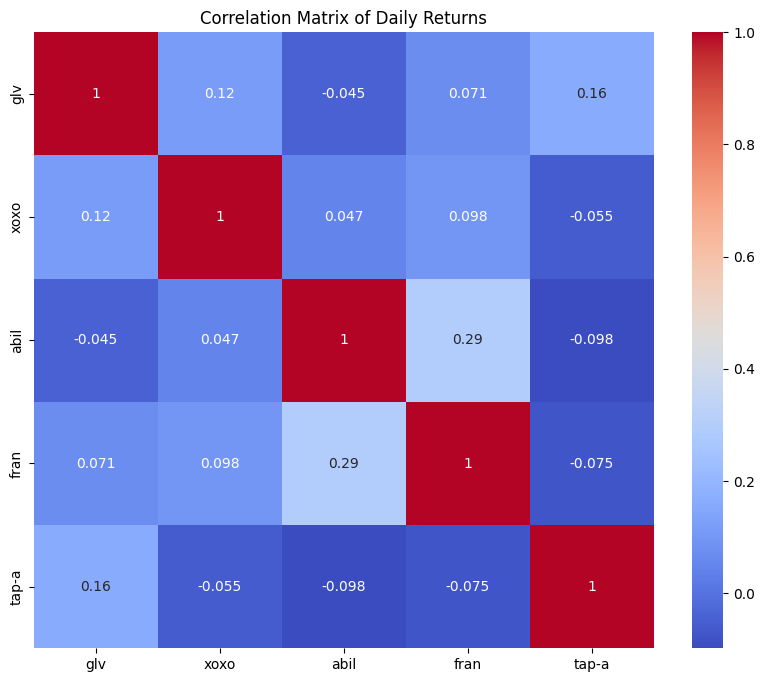

In [21]:
import seaborn as sns

# Correlation matrix
correlation = returns.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Daily Returns")
plt.show()


# Models

 XGBoost Regressor

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Using one ticker, e.g., first one
ticker = close_prices.columns[0]
data = close_prices[ticker].dropna()

# Feature engineering
df = pd.DataFrame(data)
df['Target'] = df[ticker].shift(-1)
df.dropna(inplace=True)

# Features: past 5 days
for i in range(1, 6):
    df[f'Lag_{i}'] = df[ticker].shift(i)
df.dropna(inplace=True)

X = df[[f'Lag_{i}' for i in range(1, 6)]]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, preds_xgb)
print(f"XGBoost MSE: {mse_xgb:.4f}")


XGBoost MSE: 0.0796


This code builds a basic time series regression model using XGBoost to predict the next day’s stock price based on the previous 5 days, serving as a baseline for more advanced financial forecasting.

LSTM Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Setting Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

# Creating sequences
def create_lstm_dataset(series, window=60):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

window = 60
X_lstm, y_lstm = create_lstm_dataset(scaled_data, window)

# Train-test split
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Model
model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(window, 1)),
    Dense(1)
])
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

# Predictions
preds_lstm = model_lstm.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, preds_lstm)
print(f"LSTM MSE: {mse_lstm:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
LSTM MSE: 0.0003


This model captures temporal dependencies in the stock price series using deep learning. It's especially suited for sequential forecasting tasks where recent trends matter.

ARIMA Model

In [28]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Train-test split
train_size = int(len(data) * 0.8)
train_arima, test_arima = data[:train_size], data[train_size:]

# ARIMA model
model_arima = ARIMA(train_arima, order=(5,1,0))
fitted_arima = model_arima.fit()
preds_arima = fitted_arima.forecast(len(test_arima))
mse_arima = mean_squared_error(test_arima, preds_arima)
print(f"ARIMA MSE: {mse_arima:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA MSE: 1.8457


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


This ARIMA model captures the linear dependencies and trends in the time series data. It's effective for forecasting stock prices when stationarity and autocorrelation are present in the data.

 # CVaR Portfolio Optimization

In [24]:
import cvxpy as cp

returns = close_prices.pct_change().dropna()
T, N = returns.shape
alpha = 0.05

w = cp.Variable(N)
z = cp.Variable(T)
VaR = cp.Variable(1)

portfolio_returns = returns.values @ w
objective = cp.Minimize(VaR + (1 / (alpha * T)) * cp.sum(z))

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    z >= 0,
    z >= -portfolio_returns - VaR
]

prob = cp.Problem(objective, constraints)
prob.solve()

opt_weights = w.value
print("Optimal Weights (CVaR):\n", dict(zip(returns.columns, np.round(opt_weights, 4))))



Optimal Weights (CVaR):
 {'glv': np.float64(0.8362), 'xoxo': np.float64(0.0184), 'abil': np.float64(0.0093), 'fran': np.float64(0.0504), 'tap-a': np.float64(0.0856)}


This code optimizes the portfolio weights based on Conditional Value at Risk (CVaR), which aims to minimize potential losses in the worst 5% (for alpha = 0.05) of the time series data. CVaR is a more conservative risk measure, useful in scenarios where extreme losses need to be minimized.

# Model Comparison Plot

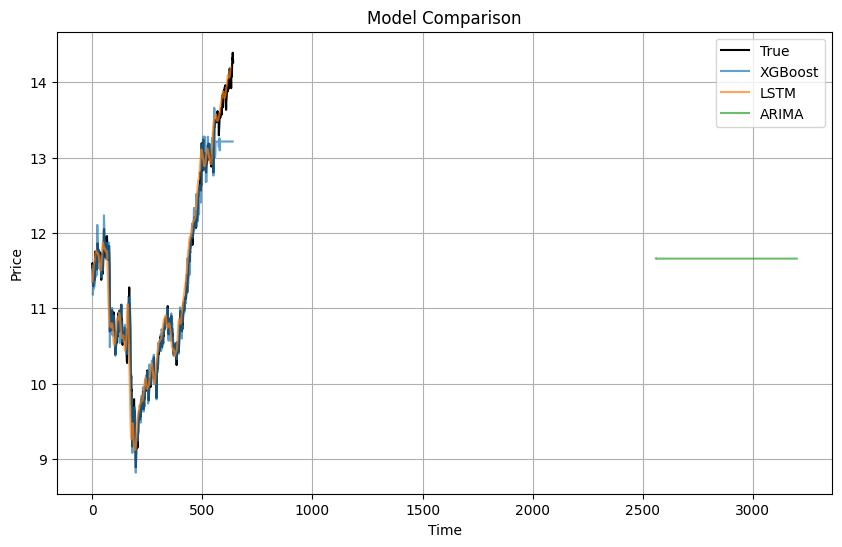

In [29]:
# Plotting model comparisons
plt.figure(figsize=(10, 6))
plt.plot(test_arima.values, label="True", color="black")
plt.plot(preds_xgb, label="XGBoost", alpha=0.7)
plt.plot(scaler.inverse_transform(preds_lstm), label="LSTM", alpha=0.7)
plt.plot(preds_arima, label="ARIMA", alpha=0.7)  # preds_arima as it is a numpy array
plt.title("Model Comparison")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# Gradio Interface

In [31]:
!pip install gradio

import gradio as gr

def predict_stock(ticker):
    if ticker not in close_prices.columns:
        return f"{ticker} not found"
    series = close_prices[ticker].dropna()

    # XGBoost example
    df = pd.DataFrame(series)
    df['Target'] = df[ticker].shift(-1)
    for i in range(1, 6):
        df[f'Lag_{i}'] = df[ticker].shift(i)
    df.dropna(inplace=True)

    X = df[[f'Lag_{i}' for i in range(1, 6)]].iloc[-1:].values
    pred_xgb = model_xgb.predict(X)[0]

    return f"XGBoost Predicted Next Close: ${pred_xgb:.2f}"

demo = gr.Interface(fn=predict_stock,
                    inputs=gr.Textbox(label="Enter Stock Ticker"),
                    outputs=gr.Textbox(label="Prediction"),
                    title="Stock Price Prediction (XGBoost)")

demo.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d5a50a5b2371084659.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory 

# Portfolio Optimization

In [33]:
# Assuming 'returns' is a DataFrame with asset returns
num_assets = returns.shape[1]  # Number of columns (assets)

# Pre-optimization weights (equal weights)
initial_weights_equal = num_assets * [1. / num_assets]

# Calculating portfolio returns for equal-weighted portfolio
initial_portfolio_returns = returns.dot(initial_weights_equal)

# Sorting returns and compute CVaR for equal-weighted portfolio
sorted_returns_initial = np.sort(initial_portfolio_returns)
var_index_initial = int(0.05 * len(sorted_returns_initial))
cvar_initial = -np.mean(sorted_returns_initial[:var_index_initial])

print(f"Pre-Optimization CVaR (Equal-Weighted Portfolio): {cvar_initial:.4f}")

Pre-Optimization CVaR (Equal-Weighted Portfolio): 0.0345


In [37]:
# Defining the objective function for optimization
def objective(weights, returns):
    # Calculating portfolio returns
    portfolio_returns = returns.dot(weights)

    # Calculating the portfolio volatility (standard deviation of returns)
    portfolio_volatility = portfolio_returns.std()

    return portfolio_volatility  # Minimize volatility (or risk)

# Setting up the constraints and bounds
# Constraints: Sum of weights should be equal to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: Each weight should be between 0 and 1
bounds = tuple((0, 1) for asset in range(returns.shape[1]))

# Initial guess for equal weights
initial_guess = np.ones(returns.shape[1]) / returns.shape[1]

# Running the optimization process
result = minimize(objective, initial_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Extracting the optimal weights
optimal_weights = result.x

# Calculating the portfolio returns using the optimized weights
optimized_portfolio_returns = returns.dot(optimal_weights)

# Sorting the optimized portfolio returns and calculate CVaR
sorted_returns_optimized = np.sort(optimized_portfolio_returns)

# Defining the confidence level for CVaR (e.g., 95%)
confidence_level = 0.05

# Calculating the Value at Risk (VaR) at the specified confidence level
VaR_optimized = np.percentile(sorted_returns_optimized, 100 * confidence_level)

# Calculating Conditional Value at Risk (CVaR) as the average of the returns below VaR
CVaR_optimized = sorted_returns_optimized[sorted_returns_optimized <= VaR_optimized].mean()

# Printing the results
print(f"Optimal Weights: {optimal_weights}")
print(f"Portfolio Return (Mean): {optimized_portfolio_returns.mean():.4f}")
print(f"Portfolio Volatility (Std Dev): {optimized_portfolio_returns.std():.4f}")
print(f"Portfolio CVaR (95%): {CVaR_optimized:.4f}")

Optimal Weights: [0.72309503 0.13458943 0.00521077 0.0260948  0.11100996]
Portfolio Return (Mean): 0.0006
Portfolio Volatility (Std Dev): 0.0050
Portfolio CVaR (95%): -0.0084


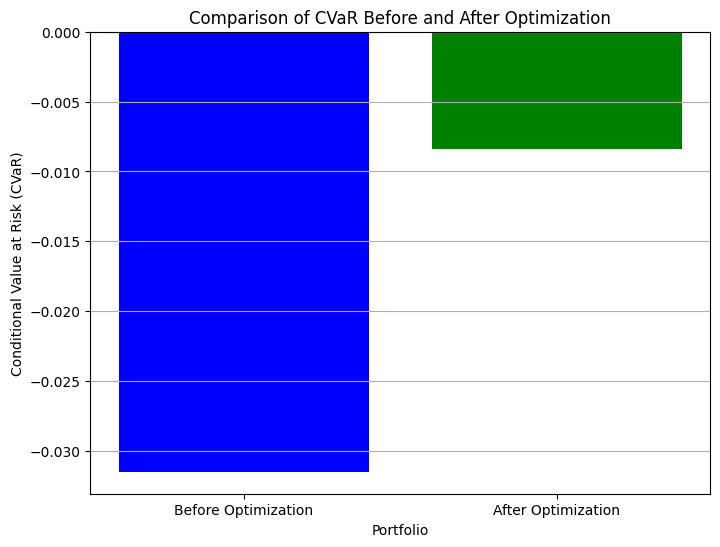

In [40]:
# Defining the equal weights (before optimization) for CVaR calculation
num_assets = returns.shape[1]  # Number of assets
equal_weights = np.ones(num_assets) / num_assets

# Calculating portfolio returns for the equal-weighted portfolio
portfolio_returns_equal = returns.dot(equal_weights)

# Sorting the portfolio returns to calculate CVaR before optimization
sorted_returns_equal = np.sort(portfolio_returns_equal)

# Calculating the Value at Risk (VaR) for the equal-weighted portfolio
VaR_equal = np.percentile(sorted_returns_equal, 100 * confidence_level)

# Calculating Conditional Value at Risk (CVaR) for the equal-weighted portfolio
CVaR_before = sorted_returns_equal[sorted_returns_equal <= VaR_equal].mean()

# Creating a DataFrame for CVaR comparison before and after optimization
cvar_comparison_data = {
    'Portfolio': ['Before Optimization', 'After Optimization'],
    'CVaR': [CVaR_before, CVaR_optimized]
}

cvar_comparison_df = pd.DataFrame(cvar_comparison_data)

# Plotting the comparison of CVaR before and after optimization
plt.figure(figsize=(8, 6))
plt.bar(cvar_comparison_df['Portfolio'], cvar_comparison_df['CVaR'], color=['blue', 'green'])
plt.title("Comparison of CVaR Before and After Optimization")
plt.ylabel("Conditional Value at Risk (CVaR)")
plt.xlabel("Portfolio")
plt.grid(True, axis='y')
plt.show()


In [41]:
# Pre-Optimization (Equal Weights)
# The equal-weighted portfolio assumes each stock has an equal weight of 1/n
initial_weights_equal = num_assets * [1. / num_assets]

# Post-Optimization (CVaR-Minimized Weights)
# The optimal weights after CVaR optimization (already computed)
optimized_weights = optimal_weights

# Displaying the Changes in Stock Weights
# Combining the initial and optimized weights into a DataFrame for comparison
weights_comparison_df = pd.DataFrame({
    'Stock': returns.columns,
    'Initial Weight (Equal)': initial_weights_equal,
    'Optimized Weight (CVaR)': optimized_weights
})

# Sorting by stock name for easier comparison
weights_comparison_df = weights_comparison_df.sort_values(by='Stock')

# Showing the weight comparison table
print("\nComparison of Stock Weights (Before and After CVaR Optimization):")
print(weights_comparison_df)




Comparison of Stock Weights (Before and After CVaR Optimization):
   Stock  Initial Weight (Equal)  Optimized Weight (CVaR)
2   abil                     0.2                 0.005211
3   fran                     0.2                 0.026095
0    glv                     0.2                 0.723095
4  tap-a                     0.2                 0.111010
1   xoxo                     0.2                 0.134589


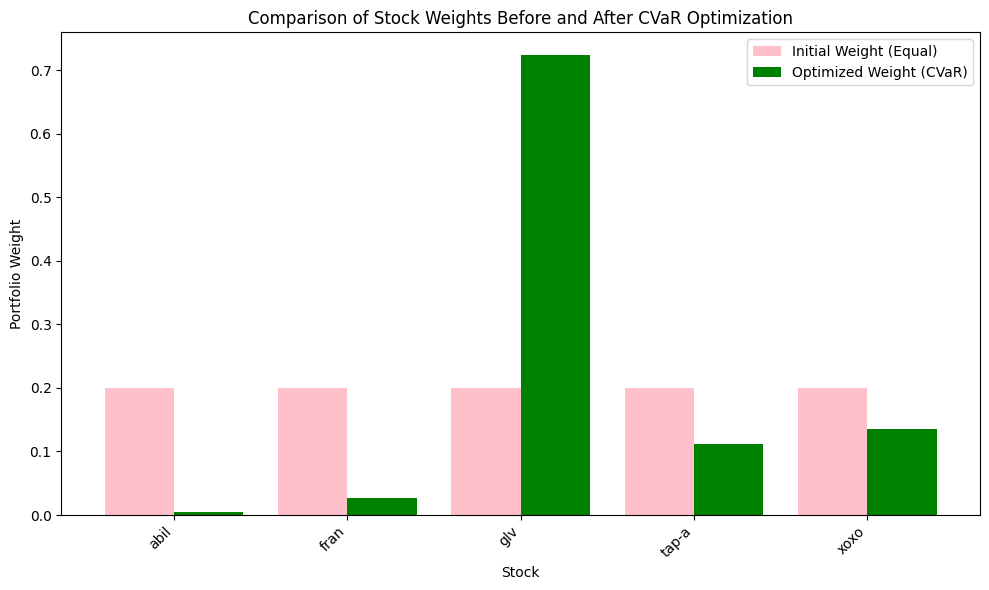

In [42]:
# Plotting Stock Weight Comparison

# Plotting a side-by-side bar chart to compare pre- and post-optimization weights
weights_comparison_df.set_index('Stock', inplace=True)
weights_comparison_df.plot(kind='bar', figsize=(10, 6), color=['pink', 'green'], width=0.8)
plt.title("Comparison of Stock Weights Before and After CVaR Optimization")
plt.ylabel("Portfolio Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()